In [23]:
import spotipy
import pandas as pd
import numpy as np
from spotipy.oauth2 import SpotifyOAuth
import time

In [24]:
client_id='c4ff820f994745288df451ea7d6940d5'
client_secret='be2297719e5e4fb698f112c4374ee3b1'
redirect_uri='https://open.spotify.com/'
token_url = "https://accounts.spotify.com/api/token"

## Project Outline

- download a dataset of spotify playlists
- find or write a library to handle genre etc analysis
- group similar playlists
- use plotting techniques to show clusters?

Project Proposal:
I am personally interested in analyzing my longterm listening and curation history through Spotify and spotipy. I have an extensive collection of playlists, which due to their regularity, can be analyzed as objects. The intention of the analysis is to uncover trends in the groupings, visualize the relative distances (similarities) of songs within playlists, and create a prediction mechanism for most similar playlists. I will use sklearn, matplotlib, and seaborn for the clustering and visualizations.

## User Auth

In [76]:
scope = 'playlist-read-private'

sp_oauth = SpotifyOAuth(client_id=client_id,client_secret=client_secret,redirect_uri=redirect_uri,scope=scope)
token_info = sp_oauth.get_cached_token() 
if not token_info:
    auth_url = sp_oauth.get_authorize_url()
    print(auth_url)
    response = input('Paste the above link into your browser, then paste the redirect url here: ')

    code = sp_oauth.parse_response_code(response)
    token_info = sp_oauth.get_access_token(code)

    token = token_info['access_token']

sp = spotipy.Spotify(auth=token, retries=10, requests_timeout=10)

https://accounts.spotify.com/authorize?client_id=c4ff820f994745288df451ea7d6940d5&response_type=code&redirect_uri=https%3A%2F%2Fopen.spotify.com%2F&scope=playlist-read-private


/var/folders/dy/m7tb4mx52sv0lxfvtf95srbc0000gn/T/ipykernel_56970/4118829141.py:11: DeprecationWarning: You're using 'as_dict = True'.get_access_token will return the token string directly in future versions. Please adjust your code accordingly, or use get_cached_token instead.
  token_info = sp_oauth.get_access_token(code)


In [29]:
# scope = 'playlist-read-private'

# oauth = spotipy.util.prompt_for_user_token(client_id=client_id, client_secret=client_secret, redirect_uri=redirect_uri, scope=scope)
# sp = spotipy.Spotify(auth=oauth)

In [30]:
if sp:
    print(sp.me())

{'display_name': 'amaya lim', 'external_urls': {'spotify': 'https://open.spotify.com/user/nightrainlily'}, 'href': 'https://api.spotify.com/v1/users/nightrainlily', 'id': 'nightrainlily', 'images': [{'url': 'https://i.scdn.co/image/ab67757000003b82180bd1d0c567a1e26710aeb8', 'height': 64, 'width': 64}, {'url': 'https://i.scdn.co/image/ab6775700000ee85180bd1d0c567a1e26710aeb8', 'height': 300, 'width': 300}], 'type': 'user', 'uri': 'spotify:user:nightrainlily', 'followers': {'href': None, 'total': 362}}


## Getting Playlists

In [31]:
from time import sleep
from tqdm import tqdm, trange

In [46]:
def get_all_playlists():
    playlist_count = 1000
    results = []
    offset = 0
    pbar = tqdm(total=1000)
    while offset < playlist_count:
        results.append(sp.current_user_playlists(limit=50, offset=offset))
        time.sleep(10)
        pbar.update(50)
        offset += 50
    pbar.close()
    return results
results = get_all_playlists()











































100%|██████████| 1000/1000 [03:30<00:00,  4.74it/s]


In [47]:
def parse(playlist_json, target):
    lst = []
    for i in np.arange(len(playlist_json['items'])):
        target_value = playlist_json['items'][i]['track'][target]
        lst.append(target_value)
    return lst 

In [48]:
import re

playlist_data = []

for result in results:
    # pbar = tqdm(total=1000)
    for playlist in result['items']:
        reg = "^([0-9])+\s([a-z]+(\s?)([a-z]?))"
        # pbar.update(1)
        if re.search(reg, playlist['name']) != None:
            track_info = sp.playlist_tracks(playlist['id'], fields='items(track(id, name))')
            playlist_data.append({
                'name' : playlist['name'],
                'track_ids' : parse(track_info, 'id'),
                'track_names' : parse(track_info, 'name'),
                'id' : playlist['id'],
                'image' : playlist['images'][0]['url']
            })
    # pbar.close()

playlists = pd.DataFrame(playlist_data)
# playlists.head().style.format({'image': lambda x : f'<img src="{x}" width="100px"/>'})
# playlists.head()

In [49]:
def pretty_tracks(col, name):
        all_l = []
        for i in np.arange(len(playlists[col])):
                row = playlists[col].values[i]
                l = []
                for j in row:
                        for k in np.arange(len(row)):
                                track = item[k]['track']
                                id = track[name]
                                l.append(id)
                all_l.append(l)
        return all_l

# playlists['track_ids'] = pretty_tracks('track_ids', 'id')
# playlists['track_names'] = pretty_tracks('track_names', 'name')

# playlists.head().style.format({'image': lambda x : f'<img src="{x}" width="100px"/>'})
playlists.head()


,name,track_ids,track_names,id,image
0,00 another dream,"[0uQo0HbOwXdPRGlNyFqGKi, 3UY4s7F4Ard3T6vm7xcJx...","[You Never Knew, Haircut, Touching Yourself, S...",538ZY5ILCTT6PxqytGgkYH,https://image-cdn-ak.spotifycdn.com/image/ab67...
1,842 what did you expect,"[0rxQTgJzd0HCUk4QUxSkjK, 1EvFahLuLZ0vSVZo8YR3G...","[Even If It Hurts (feat. Blood Orange), Due We...",0KgwFInw8xWYmtDQWayf2p,https://mosaic.scdn.co/640/ab67616d00001e02145...
2,841 promise i'm better,"[12UQIJePnGeLmpVReYpG2w, 6ELP6nqqRDftftpjgioiW...","[Sunny day, Getting Older, Mutations, Le Templ...",6OrcGRAMqQ3A6o2zCmqTj5,https://mosaic.scdn.co/640/ab67616d00001e02384...
3,840 it falls apart,"[10cGyorRXoOc9RhVhY9Sru, 2TPy9mk2KVIwSXrqwgKk2...","[She's Leaving You, Warmest Part of the Winter...",2rARwXlp3rvRwTDnT6KXXu,https://mosaic.scdn.co/640/ab67616d00001e02012...
4,840 pretty woman,"[35tWhD29yvWwB0IDRr6zsL, 5sMEEjviCkH6Rp5X2ZvII...","[Yeah Right, Everything is romantic, Frank's T...",6T6cMAfk5OTqGcs3L1gUUU,https://image-cdn-ak.spotifycdn.com/image/ab67...


## Getting Song Data

In [57]:
songs = playlists
songs['zipp'] = list(zip(songs['track_ids'], songs['track_names']))

In [58]:
def merge(z):
    return list(tuple(zip(z[0], z[1])))

songs['zipp'] = songs['zipp'].apply(merge)
songs.head()

,name,track_ids,track_names,id,image,zipp
0,00 another dream,"[0uQo0HbOwXdPRGlNyFqGKi, 3UY4s7F4Ard3T6vm7xcJx...","[You Never Knew, Haircut, Touching Yourself, S...",538ZY5ILCTT6PxqytGgkYH,https://image-cdn-ak.spotifycdn.com/image/ab67...,"[(0uQo0HbOwXdPRGlNyFqGKi, You Never Knew), (3U..."
1,842 what did you expect,"[0rxQTgJzd0HCUk4QUxSkjK, 1EvFahLuLZ0vSVZo8YR3G...","[Even If It Hurts (feat. Blood Orange), Due We...",0KgwFInw8xWYmtDQWayf2p,https://mosaic.scdn.co/640/ab67616d00001e02145...,"[(0rxQTgJzd0HCUk4QUxSkjK, Even If It Hurts (fe..."
2,841 promise i'm better,"[12UQIJePnGeLmpVReYpG2w, 6ELP6nqqRDftftpjgioiW...","[Sunny day, Getting Older, Mutations, Le Templ...",6OrcGRAMqQ3A6o2zCmqTj5,https://mosaic.scdn.co/640/ab67616d00001e02384...,"[(12UQIJePnGeLmpVReYpG2w, Sunny day), (6ELP6nq..."
3,840 it falls apart,"[10cGyorRXoOc9RhVhY9Sru, 2TPy9mk2KVIwSXrqwgKk2...","[She's Leaving You, Warmest Part of the Winter...",2rARwXlp3rvRwTDnT6KXXu,https://mosaic.scdn.co/640/ab67616d00001e02012...,"[(10cGyorRXoOc9RhVhY9Sru, She's Leaving You), ..."
4,840 pretty woman,"[35tWhD29yvWwB0IDRr6zsL, 5sMEEjviCkH6Rp5X2ZvII...","[Yeah Right, Everything is romantic, Frank's T...",6T6cMAfk5OTqGcs3L1gUUU,https://image-cdn-ak.spotifycdn.com/image/ab67...,"[(35tWhD29yvWwB0IDRr6zsL, Yeah Right), (5sMEEj..."


In [59]:
songs = songs.explode('zipp')
songs.head()

,name,track_ids,track_names,id,image,zipp
0,00 another dream,"[0uQo0HbOwXdPRGlNyFqGKi, 3UY4s7F4Ard3T6vm7xcJx...","[You Never Knew, Haircut, Touching Yourself, S...",538ZY5ILCTT6PxqytGgkYH,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(0uQo0HbOwXdPRGlNyFqGKi, You Never Knew)"
0,00 another dream,"[0uQo0HbOwXdPRGlNyFqGKi, 3UY4s7F4Ard3T6vm7xcJx...","[You Never Knew, Haircut, Touching Yourself, S...",538ZY5ILCTT6PxqytGgkYH,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(3UY4s7F4Ard3T6vm7xcJxQ, Haircut)"
0,00 another dream,"[0uQo0HbOwXdPRGlNyFqGKi, 3UY4s7F4Ard3T6vm7xcJx...","[You Never Knew, Haircut, Touching Yourself, S...",538ZY5ILCTT6PxqytGgkYH,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(1HfsmNlg8xxhOr9N2i4Q0n, Touching Yourself)"
0,00 another dream,"[0uQo0HbOwXdPRGlNyFqGKi, 3UY4s7F4Ard3T6vm7xcJx...","[You Never Knew, Haircut, Touching Yourself, S...",538ZY5ILCTT6PxqytGgkYH,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(5ksM8r8u4AjMwvtqUif9W1, Slide Tackle)"
0,00 another dream,"[0uQo0HbOwXdPRGlNyFqGKi, 3UY4s7F4Ard3T6vm7xcJx...","[You Never Knew, Haircut, Touching Yourself, S...",538ZY5ILCTT6PxqytGgkYH,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(2IM2fs9rVuDbqtuXpycvam, rangerover - Bonus Tr..."


In [60]:
songs['track_name'] = songs['zipp'].map(lambda x: x[1])
songs['track_id'] = songs['zipp'].map(lambda x: x[0])
songs.head()

,name,track_ids,track_names,id,image,zipp,track_name,track_id
0,00 another dream,"[0uQo0HbOwXdPRGlNyFqGKi, 3UY4s7F4Ard3T6vm7xcJx...","[You Never Knew, Haircut, Touching Yourself, S...",538ZY5ILCTT6PxqytGgkYH,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(0uQo0HbOwXdPRGlNyFqGKi, You Never Knew)",You Never Knew,0uQo0HbOwXdPRGlNyFqGKi
0,00 another dream,"[0uQo0HbOwXdPRGlNyFqGKi, 3UY4s7F4Ard3T6vm7xcJx...","[You Never Knew, Haircut, Touching Yourself, S...",538ZY5ILCTT6PxqytGgkYH,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(3UY4s7F4Ard3T6vm7xcJxQ, Haircut)",Haircut,3UY4s7F4Ard3T6vm7xcJxQ
0,00 another dream,"[0uQo0HbOwXdPRGlNyFqGKi, 3UY4s7F4Ard3T6vm7xcJx...","[You Never Knew, Haircut, Touching Yourself, S...",538ZY5ILCTT6PxqytGgkYH,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(1HfsmNlg8xxhOr9N2i4Q0n, Touching Yourself)",Touching Yourself,1HfsmNlg8xxhOr9N2i4Q0n
0,00 another dream,"[0uQo0HbOwXdPRGlNyFqGKi, 3UY4s7F4Ard3T6vm7xcJx...","[You Never Knew, Haircut, Touching Yourself, S...",538ZY5ILCTT6PxqytGgkYH,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(5ksM8r8u4AjMwvtqUif9W1, Slide Tackle)",Slide Tackle,5ksM8r8u4AjMwvtqUif9W1
0,00 another dream,"[0uQo0HbOwXdPRGlNyFqGKi, 3UY4s7F4Ard3T6vm7xcJx...","[You Never Knew, Haircut, Touching Yourself, S...",538ZY5ILCTT6PxqytGgkYH,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(2IM2fs9rVuDbqtuXpycvam, rangerover - Bonus Tr...",rangerover - Bonus Track,2IM2fs9rVuDbqtuXpycvam


In [61]:
songs.reset_index()

,index,name,track_ids,track_names,id,image,zipp,track_name,track_id
0,0,00 another dream,"[0uQo0HbOwXdPRGlNyFqGKi, 3UY4s7F4Ard3T6vm7xcJx...","[You Never Knew, Haircut, Touching Yourself, S...",538ZY5ILCTT6PxqytGgkYH,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(0uQo0HbOwXdPRGlNyFqGKi, You Never Knew)",You Never Knew,0uQo0HbOwXdPRGlNyFqGKi
1,0,00 another dream,"[0uQo0HbOwXdPRGlNyFqGKi, 3UY4s7F4Ard3T6vm7xcJx...","[You Never Knew, Haircut, Touching Yourself, S...",538ZY5ILCTT6PxqytGgkYH,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(3UY4s7F4Ard3T6vm7xcJxQ, Haircut)",Haircut,3UY4s7F4Ard3T6vm7xcJxQ
2,0,00 another dream,"[0uQo0HbOwXdPRGlNyFqGKi, 3UY4s7F4Ard3T6vm7xcJx...","[You Never Knew, Haircut, Touching Yourself, S...",538ZY5ILCTT6PxqytGgkYH,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(1HfsmNlg8xxhOr9N2i4Q0n, Touching Yourself)",Touching Yourself,1HfsmNlg8xxhOr9N2i4Q0n
3,0,00 another dream,"[0uQo0HbOwXdPRGlNyFqGKi, 3UY4s7F4Ard3T6vm7xcJx...","[You Never Knew, Haircut, Touching Yourself, S...",538ZY5ILCTT6PxqytGgkYH,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(5ksM8r8u4AjMwvtqUif9W1, Slide Tackle)",Slide Tackle,5ksM8r8u4AjMwvtqUif9W1
4,0,00 another dream,"[0uQo0HbOwXdPRGlNyFqGKi, 3UY4s7F4Ard3T6vm7xcJx...","[You Never Knew, Haircut, Touching Yourself, S...",538ZY5ILCTT6PxqytGgkYH,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(2IM2fs9rVuDbqtuXpycvam, rangerover - Bonus Tr...",rangerover - Bonus Track,2IM2fs9rVuDbqtuXpycvam
...,...,...,...,...,...,...,...,...,...
9692,926,007 all this time // taste for the relevant,"[1DrlLvlYd1FIjNavRm6NdX, 15jNKKCmLjyGQnKzphBiO...","[Back Pocket, Front Tooth, Does It Feel Real, ...",2Gg4bWhMij2PXtI6AGvPPS,https://mosaic.scdn.co/640/ab67616d00001e0216a...,"(4YZbVct8l9MnAVIROnLQdx, Forrest Gump)",Forrest Gump,4YZbVct8l9MnAVIROnLQdx
9693,926,007 all this time // taste for the relevant,"[1DrlLvlYd1FIjNavRm6NdX, 15jNKKCmLjyGQnKzphBiO...","[Back Pocket, Front Tooth, Does It Feel Real, ...",2Gg4bWhMij2PXtI6AGvPPS,https://mosaic.scdn.co/640/ab67616d00001e0216a...,"(0DXlHWi8pqB5R2gfzlZx2i, No Better)",No Better,0DXlHWi8pqB5R2gfzlZx2i
9694,926,007 all this time // taste for the relevant,"[1DrlLvlYd1FIjNavRm6NdX, 15jNKKCmLjyGQnKzphBiO...","[Back Pocket, Front Tooth, Does It Feel Real, ...",2Gg4bWhMij2PXtI6AGvPPS,https://mosaic.scdn.co/640/ab67616d00001e0216a...,"(4M2t7bP4Mq87mGMn0PObUX, untitled 06 | 06.30.2...",untitled 06 | 06.30.2014.,4M2t7bP4Mq87mGMn0PObUX
9695,926,007 all this time // taste for the relevant,"[1DrlLvlYd1FIjNavRm6NdX, 15jNKKCmLjyGQnKzphBiO...","[Back Pocket, Front Tooth, Does It Feel Real, ...",2Gg4bWhMij2PXtI6AGvPPS,https://mosaic.scdn.co/640/ab67616d00001e0216a...,"(0ekkYaWO7OR9RBWtOcGPKM, Herringbone)",Herringbone,0ekkYaWO7OR9RBWtOcGPKM


In [71]:
songs = songs.dropna()

### Audio Features

In [80]:
def batch(lst, n):
    for i in range(0, len(lst), n):
        if len(lst) >= (i+n):
            yield lst[i:i + n]
        else:
            yield lst[i:]

def get_audio_features(uris):
    results = []
    pbar = tqdm(total=1000)
    batched = batch(uris, 100)
    for each in batched:
        results.append(sp.audio_features(each))
        pbar.update(50)
    pbar.close()
    return results

In [81]:
audio_features_results = get_audio_features(songs['track_id'])







































































































































































































































































































4850it [00:23, 203.02it/s]


In [109]:
unpacked = [song for hundred in audio_features_results for song in hundred]
unpacked

[{'danceability': 0.738,
  'energy': 0.707,
  'key': 7,
  'loudness': -5.966,
  'mode': 1,
  'speechiness': 0.0265,
  'acousticness': 0.143,
  'instrumentalness': 9.85e-06,
  'liveness': 0.105,
  'valence': 0.808,
  'tempo': 117.999,
  'type': 'audio_features',
  'id': '0uQo0HbOwXdPRGlNyFqGKi',
  'uri': 'spotify:track:0uQo0HbOwXdPRGlNyFqGKi',
  'track_href': 'https://api.spotify.com/v1/tracks/0uQo0HbOwXdPRGlNyFqGKi',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/0uQo0HbOwXdPRGlNyFqGKi',
  'duration_ms': 269227,
  'time_signature': 4},
 {'danceability': 0.779,
  'energy': 0.495,
  'key': 8,
  'loudness': -7.621,
  'mode': 1,
  'speechiness': 0.0381,
  'acousticness': 0.731,
  'instrumentalness': 0.000332,
  'liveness': 0.132,
  'valence': 0.546,
  'tempo': 128.992,
  'type': 'audio_features',
  'id': '3UY4s7F4Ard3T6vm7xcJxQ',
  'uri': 'spotify:track:3UY4s7F4Ard3T6vm7xcJxQ',
  'track_href': 'https://api.spotify.com/v1/tracks/3UY4s7F4Ard3T6vm7xcJxQ',
  'analysis_url': 'http

In [111]:
features = pd.DataFrame(unpacked)
features.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.738,0.707,7,-5.966,1,0.0265,0.1430,0.000010,0.1050,0.808,117.999,audio_features,0uQo0HbOwXdPRGlNyFqGKi,spotify:track:0uQo0HbOwXdPRGlNyFqGKi,https://api.spotify.com/v1/tracks/0uQo0HbOwXdP...,https://api.spotify.com/v1/audio-analysis/0uQo...,269227,4
1,0.779,0.495,8,-7.621,1,0.0381,0.7310,0.000332,0.1320,0.546,128.992,audio_features,3UY4s7F4Ard3T6vm7xcJxQ,spotify:track:3UY4s7F4Ard3T6vm7xcJxQ,https://api.spotify.com/v1/tracks/3UY4s7F4Ard3...,https://api.spotify.com/v1/audio-analysis/3UY4...,216003,4
2,0.714,0.680,3,-5.989,1,0.0260,0.1350,0.000002,0.2290,0.934,108.001,audio_features,1HfsmNlg8xxhOr9N2i4Q0n,spotify:track:1HfsmNlg8xxhOr9N2i4Q0n,https://api.spotify.com/v1/tracks/1HfsmNlg8xxh...,https://api.spotify.com/v1/audio-analysis/1Hfs...,181587,4
3,0.746,0.603,5,-6.516,1,0.0297,0.0178,0.013900,0.0573,0.874,127.989,audio_features,5ksM8r8u4AjMwvtqUif9W1,spotify:track:5ksM8r8u4AjMwvtqUif9W1,https://api.spotify.com/v1/tracks/5ksM8r8u4AjM...,https://api.spotify.com/v1/audio-analysis/5ksM...,219783,4
4,0.634,0.654,4,-5.351,0,0.0547,0.0584,0.000000,0.1990,0.782,149.782,audio_features,2IM2fs9rVuDbqtuXpycvam,spotify:track:2IM2fs9rVuDbqtuXpycvam,https://api.spotify.com/v1/tracks/2IM2fs9rVuDb...,https://api.spotify.com/v1/audio-analysis/2IM2...,135703,4


In [113]:
songs_features = songs.merge(features,  left_on='track_id', right_on='id')
songs_features.head()

,name,track_ids,track_names,id_x,image,zipp,track_name,track_id,danceability,energy,...,liveness,valence,tempo,type,id_y,uri,track_href,analysis_url,duration_ms,time_signature
0,00 another dream,"[0uQo0HbOwXdPRGlNyFqGKi, 3UY4s7F4Ard3T6vm7xcJx...","[You Never Knew, Haircut, Touching Yourself, S...",538ZY5ILCTT6PxqytGgkYH,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(0uQo0HbOwXdPRGlNyFqGKi, You Never Knew)",You Never Knew,0uQo0HbOwXdPRGlNyFqGKi,0.738,0.707,...,0.105,0.808,117.999,audio_features,0uQo0HbOwXdPRGlNyFqGKi,spotify:track:0uQo0HbOwXdPRGlNyFqGKi,https://api.spotify.com/v1/tracks/0uQo0HbOwXdP...,https://api.spotify.com/v1/audio-analysis/0uQo...,269227,4
1,00 another dream,"[0uQo0HbOwXdPRGlNyFqGKi, 3UY4s7F4Ard3T6vm7xcJx...","[You Never Knew, Haircut, Touching Yourself, S...",538ZY5ILCTT6PxqytGgkYH,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(3UY4s7F4Ard3T6vm7xcJxQ, Haircut)",Haircut,3UY4s7F4Ard3T6vm7xcJxQ,0.779,0.495,...,0.132,0.546,128.992,audio_features,3UY4s7F4Ard3T6vm7xcJxQ,spotify:track:3UY4s7F4Ard3T6vm7xcJxQ,https://api.spotify.com/v1/tracks/3UY4s7F4Ard3...,https://api.spotify.com/v1/audio-analysis/3UY4...,216003,4
2,00 another dream,"[0uQo0HbOwXdPRGlNyFqGKi, 3UY4s7F4Ard3T6vm7xcJx...","[You Never Knew, Haircut, Touching Yourself, S...",538ZY5ILCTT6PxqytGgkYH,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(3UY4s7F4Ard3T6vm7xcJxQ, Haircut)",Haircut,3UY4s7F4Ard3T6vm7xcJxQ,0.779,0.495,...,0.132,0.546,128.992,audio_features,3UY4s7F4Ard3T6vm7xcJxQ,spotify:track:3UY4s7F4Ard3T6vm7xcJxQ,https://api.spotify.com/v1/tracks/3UY4s7F4Ard3...,https://api.spotify.com/v1/audio-analysis/3UY4...,216003,4
3,00 another dream,"[0uQo0HbOwXdPRGlNyFqGKi, 3UY4s7F4Ard3T6vm7xcJx...","[You Never Knew, Haircut, Touching Yourself, S...",538ZY5ILCTT6PxqytGgkYH,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(1HfsmNlg8xxhOr9N2i4Q0n, Touching Yourself)",Touching Yourself,1HfsmNlg8xxhOr9N2i4Q0n,0.714,0.680,...,0.229,0.934,108.001,audio_features,1HfsmNlg8xxhOr9N2i4Q0n,spotify:track:1HfsmNlg8xxhOr9N2i4Q0n,https://api.spotify.com/v1/tracks/1HfsmNlg8xxh...,https://api.spotify.com/v1/audio-analysis/1Hfs...,181587,4
4,00 another dream,"[0uQo0HbOwXdPRGlNyFqGKi, 3UY4s7F4Ard3T6vm7xcJx...","[You Never Knew, Haircut, Touching Yourself, S...",538ZY5ILCTT6PxqytGgkYH,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(1HfsmNlg8xxhOr9N2i4Q0n, Touching Yourself)",Touching Yourself,1HfsmNlg8xxhOr9N2i4Q0n,0.714,0.680,...,0.229,0.934,108.001,audio_features,1HfsmNlg8xxhOr9N2i4Q0n,spotify:track:1HfsmNlg8xxhOr9N2i4Q0n,https://api.spotify.com/v1/tracks/1HfsmNlg8xxh...,https://api.spotify.com/v1/audio-analysis/1Hfs...,181587,4


In [114]:
playlist_features = songs_features[['name', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']].groupby('name').mean().reset_index()
playlist_features.head()

,name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,00 all yours,0.601727,0.603500,6.636364,-7.969091,0.818182,0.043895,0.336721,0.001925,0.185964,0.584273,116.563455
1,00 alright,0.654107,0.690214,3.392857,-6.449357,1.000000,0.069704,0.141444,0.004392,0.108479,0.426929,128.991821
2,00 another dream,0.691611,0.594611,5.944444,-6.660667,0.666667,0.050361,0.301017,0.029094,0.158089,0.693444,112.857056
3,00 before you go,0.512450,0.381100,5.450000,-8.687800,0.900000,0.045560,0.591110,0.000547,0.179050,0.221140,118.881300
4,00 call it love,0.570381,0.690286,2.571429,-8.432810,0.714286,0.055090,0.193886,0.120606,0.121214,0.612714,119.978333


In [131]:
playlists.to_pickle('cached_playlists')
songs.to_pickle('cached_songs')
features.to_pickle('cached_features')

In [ ]:
# clustering
# k mediods
# silhouette coefficient plotting
# visualization
# input-output mechanism

### PCA

In [127]:
from sklearn.decomposition import PCA

In [128]:
X = playlist_features.set_index('name')

pca = PCA(n_components=3)

pc = pd.DataFrame(pca.fit_transform(X))
pc.head()

,0,1,2
0,-2.312921,1.466722,1.523010
1,10.154349,2.327931,-1.819237
2,-5.970816,2.870933,0.758600
3,-0.028154,0.546711,0.378734
4,1.071680,0.654690,-2.503890


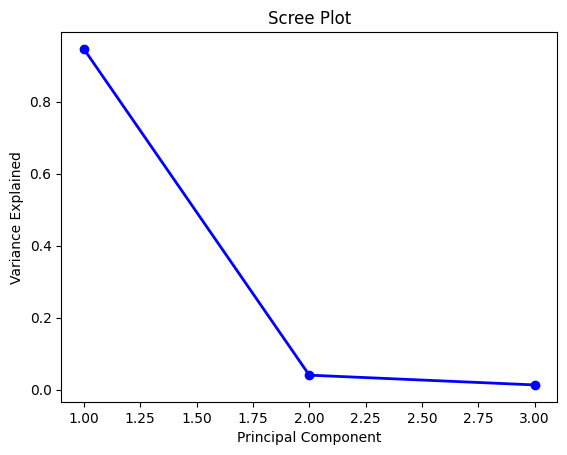

In [129]:
import matplotlib.pyplot as plt

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [130]:
pc['name'] = playlist_features['name']
pc.columns = ['pc1', 'pc2', 'pc3', 'name']
pc.head()

,pc1,pc2,pc3,name
0,-2.312921,1.466722,1.523010,00 all yours
1,10.154349,2.327931,-1.819237,00 alright
2,-5.970816,2.870933,0.758600,00 another dream
3,-0.028154,0.546711,0.378734,00 before you go
4,1.071680,0.654690,-2.503890,00 call it love


### Clustering

In [116]:
from sklearn_extra.cluster import KMedoids as kmedoids
from sklearn.metrics import silhouette_score

  0%|          | 0/1000 [24:23<?, ?it/s]
3900it [23:41,  2.74it/s]
  0%|          | 0/1000 [23:51<?, ?it/s]


In [138]:
# cluster_X = pd.concat([X, pc], axis=1, join='inner')

# X = playlist_features.drop(['key', 'mode'], axis=1).set_index('name')
X= pc.set_index('name')

In [139]:
s_scores = []

num_clusters = 1
low_score = -1
for i in range(2, 30):
    s = silhouette_score(X, kmedoids(n_clusters=i, random_state=42).fit_predict(X))
    s_scores.append(s)
    if s > low_score:
        low_score = s
        num_clusters = i

print(num_clusters)

2


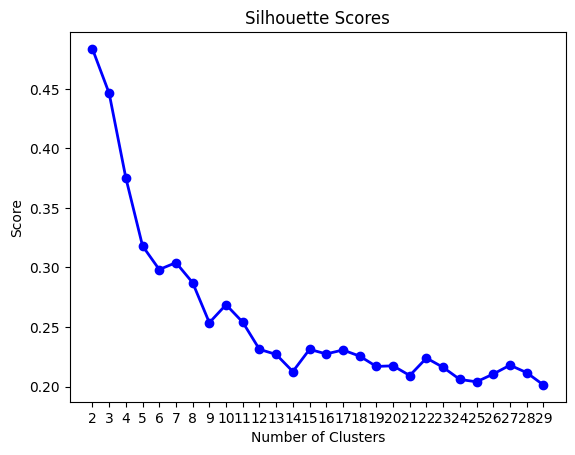

In [140]:
import matplotlib.pyplot as plt

plt.plot(range(2, 30), s_scores, 'o-', linewidth=2, color='blue')
plt.xticks(range(2, 30))
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.show()

In [141]:
km = kmedoids(n_clusters=7)
clusters = km.fit_predict(X)

X['cluster'] = clusters

In [142]:
X.head()

,pc1,pc2,pc3,cluster
name,,,,
00 all yours,-2.312921,1.466722,1.523010,4
00 alright,10.154349,2.327931,-1.819237,6
00 another dream,-5.970816,2.870933,0.758600,4
00 before you go,-0.028154,0.546711,0.378734,5
00 call it love,1.071680,0.654690,-2.503890,3


In [144]:
cluster0 = X.loc[X['cluster'] == 0]
cluster0.index

Index(['00 change', '00 don't forget me', '00 everything', '00 ghost',
       '00 hold me forever', '00 i hope i never lose you',
       '00 i keep thinking', '00 i love you more', '00 no fool', '00 promise',
       ...
       '797 the way you look at me', '801 the real thing', '807 keep my cool',
       '819 love me to death', '820 surrender', '828 more than i can give',
       '831 if it's forever', '835 maybe tomorrow', '837 no pretending',
       '90 growing pains/good times'],
      dtype='object', name='name', length=176)

### Visualization

In [145]:
import seaborn as sns

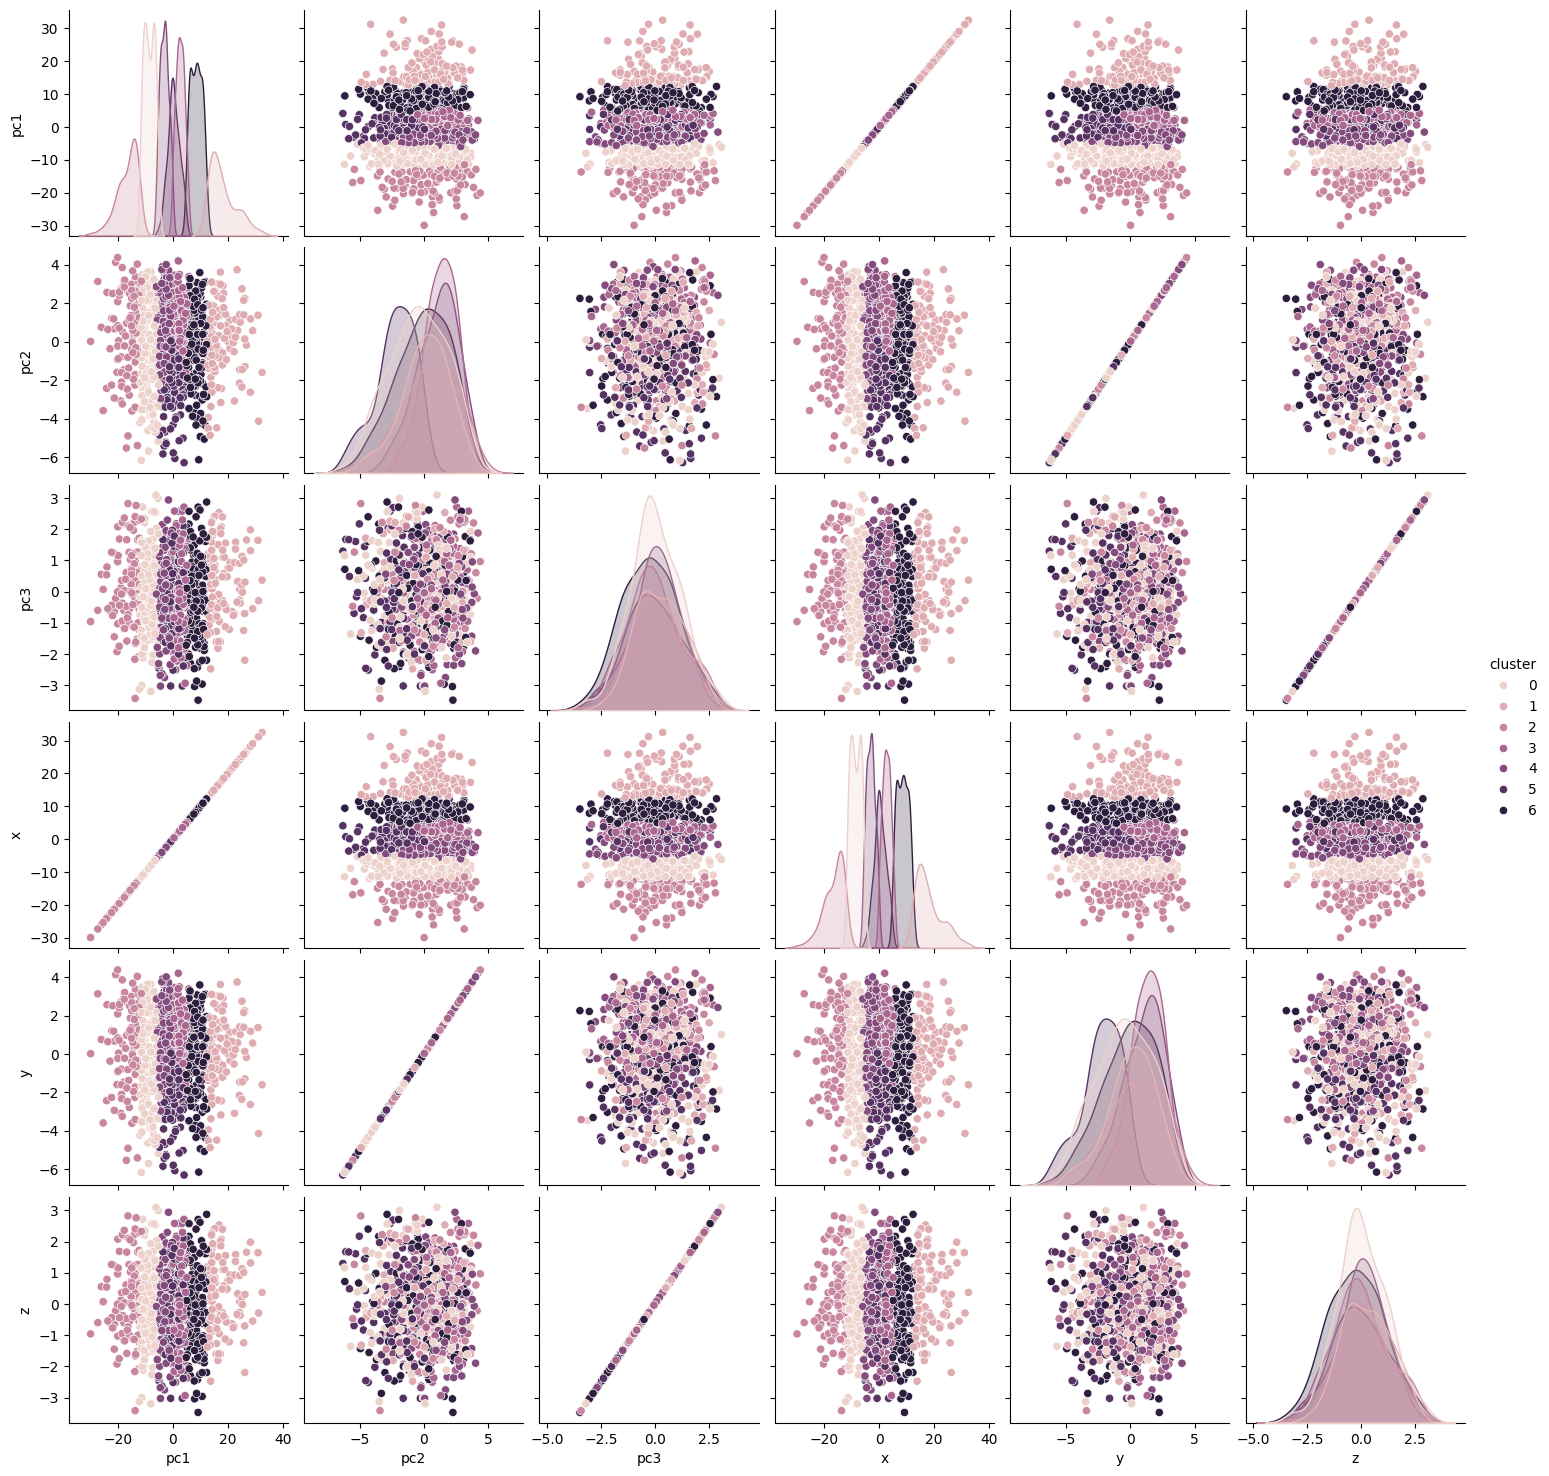

In [151]:
df_3d = X
df_3d['x'] = X['pc1']
df_3d['y'] = X['pc2']
df_3d['z'] = X['pc3']

sns.pairplot(df_3d, hue='cluster')

### Recommendation System